<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/video_games/game_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emot
!pip install -U adapter-transformers
!pip install datasets

     |████████████████████████████████| 61 kB 25 kB/s 
     |████████████████████████████████| 3.9 MB 4.3 MB/s 
     |████████████████████████████████| 880 kB 24.2 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 596 kB 42.9 MB/s 
     |████████████████████████████████| 6.6 MB 66.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=a291d6bade2500a06fcf6b58e2ca332e29c1c3eaeb15bd1477ae7b601801ae4e
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 346 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 73.6 MB/s 
     |████████████████████████████████| 212 kB 84.1 MB/s 
     |████████████████████████████████|

In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

import torch
from transformers import RobertaTokenizer
import datasets
from datasets import Dataset
from transformers import RobertaConfig, RobertaModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load game data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/game/97_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/game/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/game/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/game/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(95385, 3)
 1.0    69406
-1.0    18035
 0.0     7944
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This game is a good time. Especially if you h...
1,0.0,2005,Don't expect the bells and whistles that you f...
2,1.0,2005,"It is fun to play this game, I really like it...."
3,1.0,2006,Here's the deal with this item: it's fine for ...
4,0.0,2006,We bought this for Christmas for our three kid...


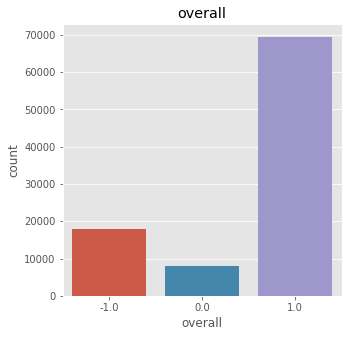

In [ ]:
# load data for 1997 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(273501, 3)
 1.0    193149
-1.0     55507
 0.0     24845
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2012,I oredered this for a daughter who is now 33 a...
1,1.0,2010,Well I thought since this idem didn't have any...
2,1.0,2012,Good game. Good graphics. A bit of a learning ...
3,-1.0,2012,"If you buy this game, you will regret it. If ..."
4,1.0,2012,4 Stars because they like it and play it often...


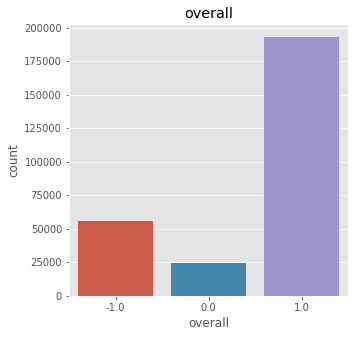

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(957163, 3)
 1.0    672584
-1.0    210099
 0.0     74480
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2014,I used to play this game years ago and loved i...
1,0.0,2014,The game itself worked great but the story lin...
2,1.0,2014,I had to learn the hard way after ordering thi...
3,-1.0,2014,The product description should state this clea...
4,1.0,2014,I would recommend this learning game for anyon...


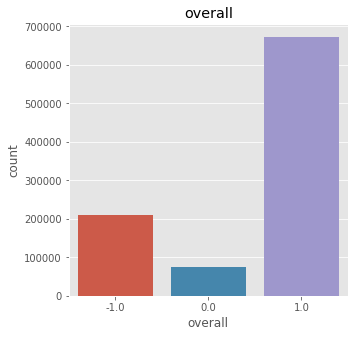

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(80396, 3)
 1.0    52744
-1.0    21618
 0.0     6034
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,No complaints! Sing your little heart out!
1,1.0,2018,Works great with Xbox 360. I have 2 of these u...
2,1.0,2018,The game was perfect and super clean. Very ple...
3,1.0,2018,It was perfect gift. Got it for Christmas and ...
4,1.0,2018,Lik3d it


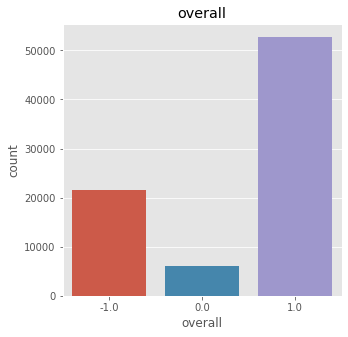

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5000 positive，5000 negative，5000 neutral

80%(12000) training and 20%(3000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4000,:]
  train_neudata = neu.iloc[:4000,:]
  train_negdata = neg.iloc[:4000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4000:5000,:]
  test_neudata = neu.iloc[4000:5000,:]
  test_negdata = neg.iloc[4000:5000,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# data for 1997 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [ ]:
df1_test.shape

(3000, 3)

## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [ ]:
df4_train.head()

,overall,reviewTime,reviewText,cleanText
81629,0.0,2018,Wii motes do not communicate with console very...,wii motes communicate console well inside stee...
61195,1.0,2018,works great no lagging and does not come unplu...,works great lagging come unplugged great reach...
41119,1.0,2018,This case is great for my vita. The console fi...,case great vita console fits good handful game...
38285,2.0,2018,wire broke after a year of on and off again us...,wire broke use wont stay connected shame worke...
56866,1.0,2018,It got to me quick and works fine.,got quick works fine


## Tokenization

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=128, truncation=True, padding="max_length")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def generate_datasetdict(dataframe1,dataframe2):
  text1 = dataframe1.cleanText.values
  text2 = dataframe2.cleanText.values

  label1 = dataframe1.overall.values.astype(np.int32)
  label2 = dataframe2.overall.values.astype(np.int32)

  train_df = pd.DataFrame({"label" : label1,"text" : text1})
  test_df = pd.DataFrame({"label" : label2,"text" : text2})

  train_dataset = Dataset.from_dict(train_df)
  test_dataset = Dataset.from_dict(test_df)
  my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

  # Encode the input data
  dataset = my_dataset_dict.map(encode_batch, batched=True)
  # The transformers model expects the target class column to be named "labels"
  # dataset.rename_column(original_column_name="label", new_column_name="labels")
  # Transform to pytorch tensors and only output the required columns
  dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  return dataset

In [ ]:
df1_dataset = generate_datasetdict(df1_train,df1_test)
df2_dataset = generate_datasetdict(df2_train,df2_test)
df3_dataset = generate_datasetdict(df3_train,df3_test)
df4_dataset = generate_datasetdict(df4_train,df4_test)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

## Train Adapters

### adapter learning from 1997-2006

In [ ]:
df1_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
df1_model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=df1_config,
)

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:255: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:233: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

In [ ]:
# Add a new adapter
df1_model.add_adapter("df1")
# Add a matching classification head
df1_model.add_classification_head(
    "df1",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
df1_model.train_adapter("df1")

In [ ]:
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

df1_trainer = AdapterTrainer(
    model=df1_model,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
df1_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.948900
400,0.796200
600,0.763300
800,0.746400
1000,0.716600
1200,0.722000
1400,0.701000
1600,0.699400
1800,0.681400
2000,0.673000


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1/head_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df1/head_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/df1/head_config.json
Module weights saved in ./training_output/checkpoint-1000/df1/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-1000/df1/head_conf

TrainOutput(global_step=2250, training_loss=0.7373784298366971, metrics={'train_runtime': 598.1017, 'train_samples_per_second': 120.381, 'train_steps_per_second': 3.762, 'total_flos': 4818162714624000.0, 'train_loss': 0.7373784298366971, 'epoch': 6.0})

In [ ]:
df1_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.6773333333333333,
 'eval_loss': 0.7378016114234924,
 'eval_runtime': 12.4881,
 'eval_samples_per_second': 240.229,
 'eval_steps_per_second': 7.527}

In [ ]:
df1_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.2472393 , -0.48387778,  0.3412734 ],
       [ 0.57810473, -1.6973372 ,  1.0523471 ],
       [ 1.3245237 , -1.238192  , -0.01354082],
       ...,
       [ 0.70935553,  1.2143195 , -1.7206265 ],
       [ 0.05574516, -1.628953  ,  1.615116  ],
       [ 0.43339753, -0.4066922 ,  0.04867516]], dtype=float32), label_ids=array([2, 2, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.7199802994728088, 'test_acc': 0.691, 'test_runtime': 12.4592, 'test_samples_per_second': 240.785, 'test_steps_per_second': 7.545})

In [ ]:
df1_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.15361187,  2.3161511 , -1.9267998 ],
       [-0.24748373,  2.6092415 , -2.1005342 ],
       [-0.9021291 , -1.4699137 ,  2.3849328 ],
       ...,
       [-0.45117584, -2.9128776 ,  3.25726   ],
       [ 0.10535526, -1.1958236 ,  1.0779943 ],
       [-0.8031585 ,  2.3465667 , -1.1685765 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 2, 0, 1]), metrics={'test_loss': 0.762687087059021, 'test_acc': 0.6666666666666666, 'test_runtime': 12.4826, 'test_samples_per_second': 240.335, 'test_steps_per_second': 7.531})

In [ ]:
df1_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.22146109,  0.7494683 , -0.75622284],
       [-0.34818962,  0.84485835, -0.33065596],
       [ 1.0052669 , -0.38607824, -0.55219984],
       ...,
       [-0.82309914, -2.1885161 ,  3.1984777 ],
       [ 0.51442766,  0.672972  , -0.9687582 ],
       [-0.6391868 , -1.1016    ,  1.9276623 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.7845906019210815, 'test_acc': 0.647, 'test_runtime': 12.471, 'test_samples_per_second': 240.559, 'test_steps_per_second': 7.538})

## adapter learning from 2007-2012

In [ ]:
df2_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
df2_model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=df2_config,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
# Add a new adapter
df2_model.add_adapter("df2")
# Add a matching classification head
df2_model.add_classification_head(
    "df2",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
df2_model.train_adapter("df2")

Adding adapter 'df2'.
Adding head 'df2' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
df2_trainer = AdapterTrainer(
    model=df2_model,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)
df2_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.957300
400,0.783000
600,0.774900
800,0.745200
1000,0.712500
1200,0.709200
1400,0.702100
1600,0.686600
1800,0.679600
2000,0.669500


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/head_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df2/head_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/df2/head_config.json
Module weights saved in ./training_output/checkpoint-1000/df2/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-1000/df2/head_conf

TrainOutput(global_step=2250, training_loss=0.7333874172634549, metrics={'train_runtime': 598.6902, 'train_samples_per_second': 120.263, 'train_steps_per_second': 3.758, 'total_flos': 4818162714624000.0, 'train_loss': 0.7333874172634549, 'epoch': 6.0})

In [ ]:
df2_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.6953333333333334,
 'eval_loss': 0.708464503288269,
 'eval_runtime': 12.4383,
 'eval_samples_per_second': 241.191,
 'eval_steps_per_second': 7.557}

In [ ]:
df2_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.926849  , -2.6856523 ,  1.4728862 ],
       [-0.39409503,  1.2984645 , -0.99178725],
       [ 0.26238653,  2.101254  , -2.2733383 ],
       ...,
       [ 0.3143319 ,  0.3668377 , -0.73012847],
       [-0.12088105, -2.538572  ,  2.2988198 ],
       [-0.6980138 , -0.9522113 ,  1.7513076 ]], dtype=float32), label_ids=array([2, 0, 1, ..., 0, 2, 2]), metrics={'test_loss': 0.7544649839401245, 'test_acc': 0.671, 'test_runtime': 12.4541, 'test_samples_per_second': 240.884, 'test_steps_per_second': 7.548})

In [ ]:
df2_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.09196896,  2.8634875 , -2.7413845 ],
       [-0.24992397,  3.0830114 , -2.7366877 ],
       [-0.6592214 , -2.3304698 ,  2.7530499 ],
       ...,
       [-0.93195546, -2.641359  ,  2.952662  ],
       [ 0.17134842, -1.3448747 ,  1.0803658 ],
       [-0.8351184 ,  3.1301064 , -2.1888137 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 2, 0, 1]), metrics={'test_loss': 0.7306997776031494, 'test_acc': 0.6773333333333333, 'test_runtime': 12.4838, 'test_samples_per_second': 240.312, 'test_steps_per_second': 7.53})

In [ ]:
df2_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.47112694,  0.11691479, -0.66476846],
       [-0.55212504,  0.9890981 , -0.48170766],
       [ 1.0579438 , -0.13931733, -0.93156844],
       ...,
       [-0.47555283, -1.7125784 ,  1.7965815 ],
       [ 0.55004877,  1.7216486 , -2.1684632 ],
       [-0.39268807, -1.1614237 ,  1.285287  ]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.7277776598930359, 'test_acc': 0.6753333333333333, 'test_runtime': 12.4636, 'test_samples_per_second': 240.701, 'test_steps_per_second': 7.542})

## adapter learning from 2013-2017

In [ ]:
df3_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
df3_model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=df3_config,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
# Add a new adapter
df3_model.add_adapter("df3")
# Add a matching classification head
df3_model.add_classification_head(
    "df3",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
df3_model.train_adapter("df3")

Adding adapter 'df3'.
Adding head 'df3' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
df3_trainer = AdapterTrainer(
    model=df3_model,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)
df3_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.933800
400,0.749500
600,0.729600
800,0.719900
1000,0.689200
1200,0.676100
1400,0.667100
1600,0.656300
1800,0.654700
2000,0.651700


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/head_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df3/head_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/df3/head_config.json
Module weights saved in ./training_output/checkpoint-1000/df3/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-1000/df3/head_conf

TrainOutput(global_step=2250, training_loss=0.7031835276285807, metrics={'train_runtime': 597.5824, 'train_samples_per_second': 120.485, 'train_steps_per_second': 3.765, 'total_flos': 4818162714624000.0, 'train_loss': 0.7031835276285807, 'epoch': 6.0})

In [ ]:
df3_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7003333333333334,
 'eval_loss': 0.6984772682189941,
 'eval_runtime': 12.4375,
 'eval_samples_per_second': 241.207,
 'eval_steps_per_second': 7.558}

In [ ]:
df3_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.0551775 , -2.251927  ,  0.8222446 ],
       [-0.5609479 ,  0.33020675,  0.07808425],
       [ 0.59570223,  2.3279402 , -2.6968307 ],
       ...,
       [ 0.4860066 ,  0.68558544, -1.1563298 ],
       [ 0.5165916 , -2.5801136 ,  1.564228  ],
       [-0.9638848 , -1.7207947 ,  2.4238746 ]], dtype=float32), label_ids=array([2, 0, 1, ..., 0, 2, 2]), metrics={'test_loss': 0.781965970993042, 'test_acc': 0.6553333333333333, 'test_runtime': 12.4502, 'test_samples_per_second': 240.961, 'test_steps_per_second': 7.55})

In [ ]:
df3_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.22475137, -0.30566242,  0.15619686],
       [ 0.6289172 , -1.9898763 ,  0.9717467 ],
       [ 1.2571524 , -0.2566042 , -1.058109  ],
       ...,
       [ 0.43741745,  2.624868  , -2.9123862 ],
       [ 0.6030327 ,  0.07306617, -0.60201836],
       [ 0.69195133,  0.6879442 , -1.2962779 ]], dtype=float32), label_ids=array([2, 2, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.7331255078315735, 'test_acc': 0.691, 'test_runtime': 12.4522, 'test_samples_per_second': 240.922, 'test_steps_per_second': 7.549})

In [ ]:
df3_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.6498651 ,  0.40280816, -1.0197089 ],
       [-0.826907  ,  2.154976  , -1.2387347 ],
       [ 1.4882026 , -0.08507812, -1.2977221 ],
       ...,
       [-0.7100813 , -3.5818095 ,  3.5654368 ],
       [ 0.47848448,  2.236386  , -2.530523  ],
       [-0.07246219, -3.3206859 ,  2.776456  ]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.6934329271316528, 'test_acc': 0.696, 'test_runtime': 12.4549, 'test_samples_per_second': 240.868, 'test_steps_per_second': 7.547})

## adapter learning from 2018

In [ ]:
df4_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
df4_model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=df4_config,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
# Add a new adapter
df4_model.add_adapter("df4")
# Add a matching classification head
df4_model.add_classification_head(
    "df4",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
df4_model.train_adapter("df4")

Adding adapter 'df4'.
Adding head 'df4' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
df4_trainer = AdapterTrainer(
    model=df4_model,
    args=training_args,
    train_dataset=df4_dataset["train"],
    eval_dataset=df4_dataset["test"],
    compute_metrics=compute_accuracy,
)
df4_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.907400
400,0.746600
600,0.711600
800,0.684600
1000,0.662800
1200,0.665800
1400,0.638700
1600,0.632900
1800,0.623900
2000,0.620400


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/head_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df4/head_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/df4/head_config.json
Module weights saved in ./training_output/checkpoint-1000/df4/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-1000/df4/head_conf

TrainOutput(global_step=2250, training_loss=0.6818794886271159, metrics={'train_runtime': 597.4717, 'train_samples_per_second': 120.508, 'train_steps_per_second': 3.766, 'total_flos': 4818162714624000.0, 'train_loss': 0.6818794886271159, 'epoch': 6.0})

In [ ]:
df4_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7073333333333334,
 'eval_loss': 0.6856222152709961,
 'eval_runtime': 12.4595,
 'eval_samples_per_second': 240.78,
 'eval_steps_per_second': 7.544}

In [ ]:
df4_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.1584277 , -2.1739972 ,  0.81143695],
       [-0.6845675 ,  0.507409  ,  0.16550857],
       [ 0.16864797,  2.5694368 , -2.5234404 ],
       ...,
       [ 0.72530174, -0.08338993, -0.73093945],
       [ 0.69508433, -2.2946298 ,  1.2051197 ],
       [-0.7249129 , -1.3400689 ,  2.0552847 ]], dtype=float32), label_ids=array([2, 0, 1, ..., 0, 2, 2]), metrics={'test_loss': 0.8041596412658691, 'test_acc': 0.6486666666666666, 'test_runtime': 12.4543, 'test_samples_per_second': 240.88, 'test_steps_per_second': 7.548})

In [ ]:
df4_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.11233726, -0.37869462,  0.3015766 ],
       [ 0.7958856 , -2.1048596 ,  1.0510587 ],
       [ 1.2234784 , -1.0433577 , -0.23776662],
       ...,
       [ 0.394432  ,  3.122594  , -3.2324536 ],
       [ 0.72309464, -0.2734056 , -0.31991312],
       [ 0.87212414,  0.54668134, -1.2660668 ]], dtype=float32), label_ids=array([2, 2, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.7502835392951965, 'test_acc': 0.6833333333333333, 'test_runtime': 12.4567, 'test_samples_per_second': 240.835, 'test_steps_per_second': 7.546})

In [ ]:
df4_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 3.1364518e-03,  2.5939260e+00, -2.3487456e+00],
       [-2.0189510e-01,  3.8347728e+00, -3.4113286e+00],
       [-1.7698640e-01, -2.6119626e+00,  2.3866322e+00],
       ...,
       [-2.4686775e-01, -3.0838873e+00,  2.8679237e+00],
       [ 3.2652801e-01, -9.3661350e-01,  6.1706322e-01],
       [-6.8291152e-01,  3.5237105e+00, -2.5089624e+00]], dtype=float32), label_ids=array([1, 1, 2, ..., 2, 0, 1]), metrics={'test_loss': 0.7130102515220642, 'test_acc': 0.701, 'test_runtime': 12.4547, 'test_samples_per_second': 240.873, 'test_steps_per_second': 7.547})